# Parallel Impact-T run

This example shows how to set up the Impact-T input files and run script, but to leave the running to the user. 



In [1]:
from impact import Impact
import os
from tempfile import TemporaryDirectory

# Nicer plotting
import matplotlib
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = (8,4)

NUMPROCS = 4 # number of processors

In [2]:
ifile = 'templates/lcls_injector/ImpactT.in'
os.path.exists(ifile)

True

In [3]:
# Make Impact object
I = Impact(ifile)

# Change some things
I.header['Np'] = 10000 //2 # Make smaller problem for speed
I.header['Nx'] = 32 //2
I.header['Ny'] = 32 //2
I.header['Nz'] = 32 //2
I.header['Dt'] = 5e-13
I.stop = 3

# Turn on MPI and set parallel domain
I.numprocs = NUMPROCS

I.path

'/var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/tmpc62lgsv1'

In [4]:
# Write input to workdir
I.write_input()

# This will be the working path
I.path

'/var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/tmpc62lgsv1'

In [5]:
!cat {I.path}/ImpactT.in

! Impact-T input file
!Npcol Nprow
2 2
!Dt Ntstep Nbunch
5e-13 1000000 1
!Dim Np Flagmap Flagerr Flagdiag Flagimg Zimage
6 5000 1 0 2 1 0.02
!Nx Ny Nz Flagbc Xrad Yrad Perdlen
16 16 16 1 0.015 0.015 45.0
!Flagdist Rstartflg Flagsbstp Nemission Temission
16 0 0 400 6.515803466731775e-12
!sigx(m) sigpx muxpx xscale pxscale xmu1(m) xmu2
0.0006 0.0 0.0 1.0 1.0 0.0 0.0
!sigy(m) sigpy muxpy yscale pyscale ymu1(m) ymu2
0.0006 0.0 0.0 1.0 1.0 0.0 0.0
!sigz(m) sigpz muxpz zscale pzscale zmu1(m) zmu2
1.27e-06 0.0 0.0 1.0 1.0 0.0 0.0
!Bcurr Bkenergy Bmass Bcharge Bfreq Tini
0.7140000000000003 1.0 511005.0 -1.0 2856000000.0 -3.249141278122655e-12
!=================== LATTICE ===================
0 0 0 -4 0.0 0.0 0.25 4e-12 /!name:change_timestep_1
0 0 0 -5 0.0 0.0 -1000.0 /!name:SC_2D_to_3D

!__________________ 1.5 cell gun __________________
! Single particle phased and scaled for 6 MeV energy
0.15 0 0 105 0.0 47537665.059089914 2856000000.0 303.93723122804266 201 0.15 0.0 0.0 0.0 0.0 0.0 0.0 /!na

# Run externally 
Parallel jobs often need to be run on special nodes and/or submitted to a queue, invoking the run script:

In [6]:
I.path

'/var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/tmpc62lgsv1'

In [7]:
!cat {I.path}/run

mpirun -n 4 /Users/chrisonian/Code/mambaforge/envs/lume-impact-dev/bin/ImpactTexe-mpi

Here we will do a quick run 

In [8]:
%%time
!cd {I.path};./run >log.txt

CPU times: user 252 ms, sys: 96 ms, total: 348 ms
Wall time: 56.5 s


In [9]:
# Save into template for the other examples to use
#OUTPATH = os.path.join(os.path.split(ifile)[0], 'output/')
#!cp {I.path}/fort* {OUTPATH}

# Collect output

In [10]:
I.verbose=True
# Load output
I.load_output()

Loaded fort 18 : Time and energy
Loaded fort 24 : RMS X information
Loaded fort 25 : RMS Y information
Loaded fort 26 : RMS Z information
Loaded fort 27 : Max amplitude information
Loaded fort 28 : Load balance and loss diagnostics
Loaded fort 29 : Cube root of third moments of the beam distribution
Loaded fort 30 : Fourth root of the fourth moments of the beam distribution
Loaded fort 32 : Covariance matrix of the beam distribution
Loaded fort 60 : Slice information of the initial distribution
Loaded fort 70 : Slice information of the final distribution
Loading particles
Loaded fort 40 : initial particle distribution at t = 0
Loaded fort 50 : final particle distribution projected to the centroid location of the bunch


Loaded write beam particles YAG02 fort.102
Converting z to t according to cathode_kinetic_energy_ref = 1.0 eV
Converted initial_particles to ParticleGroup
Converted final_particles to ParticleGroup
Converted YAG02 to ParticleGroup


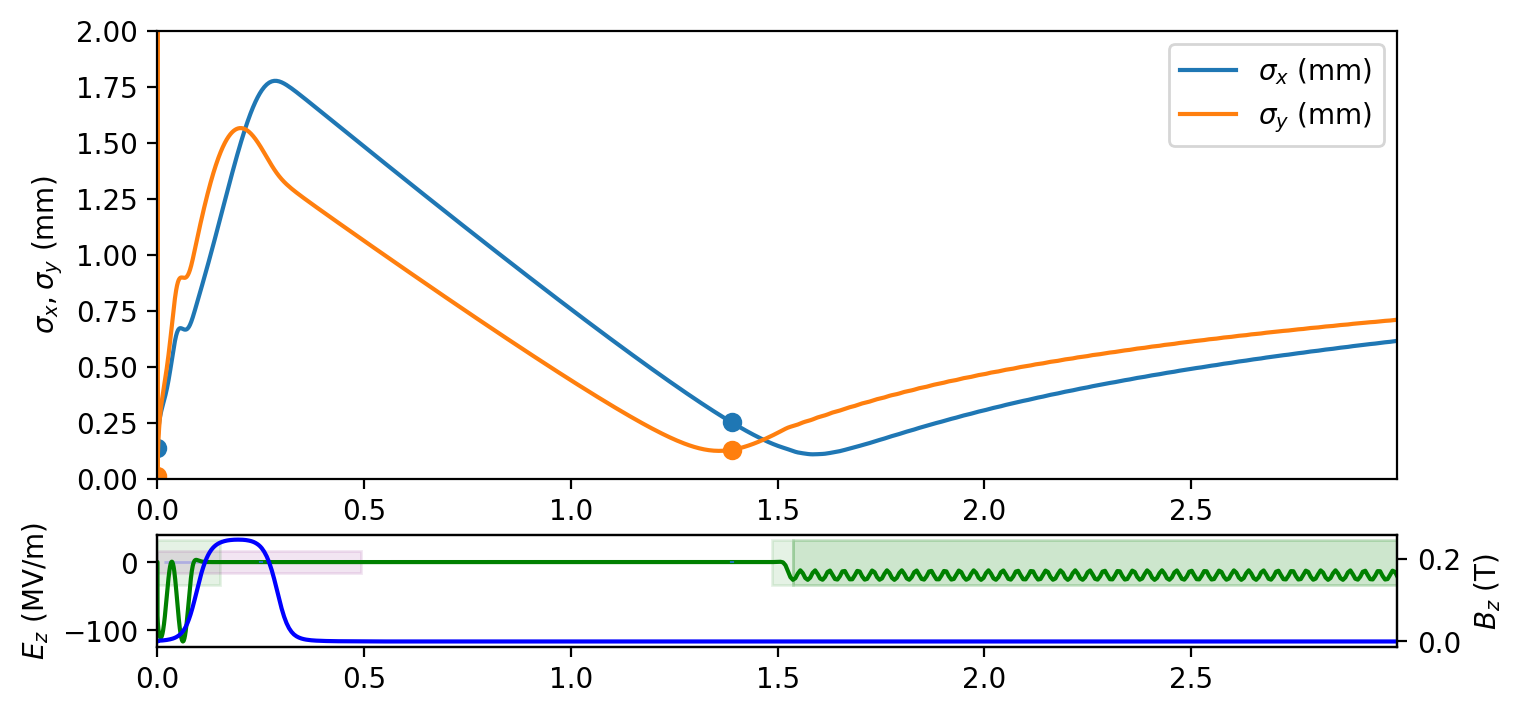

In [11]:
I.plot(ylim=(0, 0.002))

# Alternative: load into new object
If this notebook went out of scope, or the run was done previously, we'd need to load the output into a new object.

In [12]:
I2 = Impact(f'{I.path}/ImpactT.in', use_temp_dir=False)

In [13]:
I2.load_output()

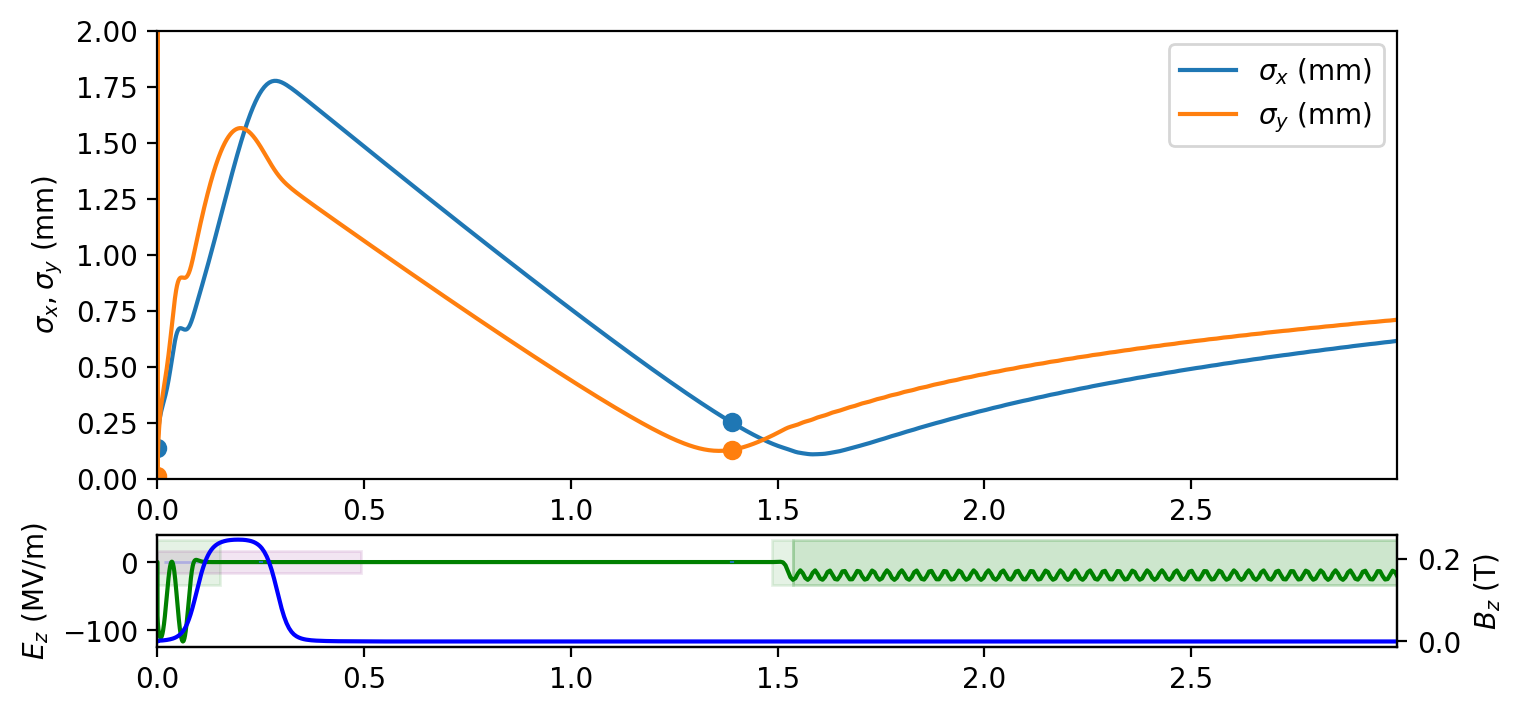

In [14]:
I.plot(ylim=(0, 0.002))

# Archiving
Archiving is the same as in the simple example

In [15]:
afile = os.path.expandvars('output.h5')
I2.archive(afile)

'output.h5'

In [16]:
# Cleanup
os.remove(afile)
